In [1]:
import ast
import re
import math
import numpy as np
import random
from tqdm import tqdm
import copy
import csv

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the font family to Times New Roman
mpl.rcParams['font.family'] = 'Times New Roman'


# Parsing Outputted Data

In [3]:
#parsing functions

def get_data(file_path):
    with open(file_path, "r") as file:
        data_str = file.read()
    return data_str

def convert_numpy_array(data_str):
    # Replace 'array([...])' with '[...]'
    data_str = re.sub(r'array\(\[', '[', data_str)
    data_str = re.sub(r'\]\)', ']', data_str)
    return data_str

def split_data(data_str):
    mc_runs = data_str.split("*DELIMITER*")
    return mc_runs

def convert_str_to_data(data_str):
    data = ast.literal_eval(data_str)
    return data

def get_specific_data(v, elem, runs):
    combined = []
    filepath = f"vector{v}.txt"
    data_str_with_numpy = get_data(filepath)
    data_str = convert_numpy_array(data_str_with_numpy)
    split_data_str = split_data(data_str)
    for run in range(runs):
        data = convert_str_to_data(split_data_str[run])
        combined.append(data[elem])
    return combined

# Graphing Data

In [20]:
def graph_grid_wide_affordability(vector, MaxIter, norm_by_pop=False):
    aff_by_quint = get_specific_data(vector, 1, num_runs)
    x = []
    for i in range(MaxIter):
        if i%25 == 0:
            x.append(i)
            
    green_colours = ["forestgreen", "limegreen", "darkgreen", "green", "lime", "seagreen", "mediumseagreen", "springgreen", "mediumaquamarine", "aquamarine", "turquoise", "lightseagreen", "mediumturquoise", "lightcyan", "paleturquoise", "darkslategray", "teal", "darkcyan", "c", "cyan", "darkturquoise", "cadetblue", "powderblue", "lightblue"]
    yellow_colours = ["bisque", "darkorange", "burlywood", "antiquewhite", "tan", "navajowhite", "blanchedalmond", "papayawhip", "moccasin", "orange", "wheat", "oldlace", "darkgoldenrod", "goldenrod", "cornsilk", "gold", "kahki", "palegoldenrod", "yellow", "beige", "lemonchiffon", "darkkhaki"]
    red_colours = ["lightcoral", "indianred", "brown", "firebrick", "red", "mistyrose", "salmon", "tomato", "darksalmon", "orangered", "crimson", "deeppink", "hotpink", "mediumvioletred", "saddlebrown", "maroon", "darkred", "lightpink", "pink", "palevioletred", "chocolate"]
    
    for run in range(len(aff_by_quint)):
        y1 = [] #affordable 
        y2 = [] #affordability stress
        y3 = [] #more than 10% (including single service and disconnected)
        for timestep in range(len(x)):
            y1.append(aff_by_quint[run][timestep][0][0] + aff_by_quint[run][timestep][0][1])
            y2.append(aff_by_quint[run][timestep][0][2] + aff_by_quint[run][timestep][0][3])
            y3.append(aff_by_quint[run][timestep][0][4] + aff_by_quint[run][timestep][0][5])
            for quintile in range(1, 5):
                y1[-1] += (aff_by_quint[run][timestep][quintile][0] + aff_by_quint[run][timestep][quintile][1])
                y2[-1] += (aff_by_quint[run][timestep][quintile][2] + aff_by_quint[run][timestep][quintile][3])
                y3[-1] += (aff_by_quint[run][timestep][quintile][4] + aff_by_quint[run][timestep][quintile][5])
        if norm_by_pop:
            population = get_specific_data(vector, 11, num_runs)[run]
            for i in range(len(y1)):
                y1[i] = y1[i]/population * 100
                y2[i] = y2[i]/population * 100
                y3[i] = y3[i]/population * 100
        plt.plot(x, y1, color=green_colours[run], linestyle="solid")
        plt.plot(x, y2, color=yellow_colours[run], linestyle="solid")
        plt.plot(x, y3, color=red_colours[run], linestyle="solid")

    plt.xlabel("months")
    plt.ylabel("Number of people")
    plt.title(f"Total affordability levels across the grid")
    if norm_by_pop:
        plt.ylabel("Percent of total population")
        plt.ylim(0, 100)
    plt.show()
    print("LEGEND\ngreeny-blue = affordable (< 5%)\nbrowny-yellow = unaffordable (> 5%)\nreds = disconnected")

    
    
def graph_aff_by_quint_run_avg_with_err(vector, timestep):
    aff_by_quints = get_specific_data(vector, 1, num_runs)
    timestep = timestep // 25
    
    avgs = [[0.0, 0.0, 0.0, 0.0] for _ in range(5)]
    std_devs = [[0.0, 0.0, 0.0, 0.0] for _ in range(5)]
    divisor = len(aff_by_quints)
    
    # Sum the values for each quintile and category i across all runs
    for run in aff_by_quints:
        for quintile in range(5):
            for i in range(4):
                avgs[quintile][i] += run[timestep][quintile][i]
            for i in range(4, 6):
                avgs[quintile][3] += run[timestep][quintile][i]
    
    # Calculate the average for each quintile and category i
    for quintile in range(5):
        for i in range(4):
            avgs[quintile][i] /= divisor
    
    # Calculate the standard deviation for each quintile and category i
    for quintile in range(5):
        for i in range(3):
            values = [run[timestep][quintile][i] for run in aff_by_quints]
            std_devs[quintile][i] = np.std(values)
        values = [run[timestep][quintile][3] + run[timestep][quintile][4] + run[timestep][quintile][5] for run in aff_by_quints]
        std_devs[quintile][3] = np.std(values)
    
    x = ["Q1", "Q2", "Q3", "Q4", "Q5", "total"]
    under_2 = np.array([0, 0, 0, 0, 0, 0])
    under_5 = np.array([0, 0, 0, 0, 0, 0])
    under_10 = np.array([0, 0, 0, 0, 0, 0])
    over_10 = np.array([0, 0, 0, 0, 0, 0])
    
    under_2_err = np.array([0, 0, 0, 0, 0, 0])
    under_5_err = np.array([0, 0, 0, 0, 0, 0])
    under_10_err = np.array([0, 0, 0, 0, 0, 0])
    over_10_err = np.array([0, 0, 0, 0, 0, 0])
    
    for quint in range(5):
        for i in range(4):
            if i == 0:
                under_2[quint] = avgs[quint][i]
                under_2_err[quint] = std_devs[quint][i]
                under_2[-1] += avgs[quint][i]
                under_2_err[-1] += std_devs[quint][i] ** 2  # Sum of variances
            if i == 1:
                under_5[quint] = avgs[quint][i]
                under_5_err[quint] = std_devs[quint][i]
                under_5[-1] += avgs[quint][i]
                under_5_err[-1] += std_devs[quint][i] ** 2
            if i == 2:
                under_10[quint] = avgs[quint][i]
                under_10_err[quint] = std_devs[quint][i]
                under_10[-1] += avgs[quint][i]
                under_10_err[-1] += std_devs[quint][i] ** 2
            if i == 3:
                over_10[quint] = avgs[quint][i]
                over_10_err[quint] = std_devs[quint][i]
                over_10[-1] += avgs[quint][i]
                over_10_err[-1] += std_devs[quint][i] ** 2
    
    # Finalise total errors, normalise by population
    under_2_err[-1] = np.sqrt(under_2_err[-1])
    under_5_err[-1] = np.sqrt(under_5_err[-1])
    under_10_err[-1] = np.sqrt(under_10_err[-1])
    over_10_err[-1] = np.sqrt(over_10_err[-1])
    
    totals = [0, 0, 0, 0, 0, 0]
    for q in range(6):
        totals[q] = under_2[q] + under_5[q] + under_10[q] + over_10[q]
                
    for q in range(6):
        under_2[q] = under_2[q] / totals[q] * 100
        under_5[q] = under_5[q] / totals[q] * 100
        under_10[q] = under_10[q] / totals[q] * 100
        over_10[q] = over_10[q] / totals[q] * 100
        
        under_2_err[q] = under_2_err[q] / totals[q] * 100
        under_5_err[q] = under_5_err[q] / totals[q] * 100
        under_10_err[q] = under_10_err[q] / totals[q] * 100
        over_10_err[q] = over_10_err[q] / totals[q] * 100
        
    under_2 = np.array(under_2, dtype=float)
    under_5 = np.array(under_5, dtype=float)
    under_10 = np.array(under_10, dtype=float)
    over_10 = np.array(over_10, dtype=float)
    
    for q in range(6):
        total = under_2[q] + under_5[q] + under_10[q] + over_10[q]
        if total != 100:
            amount_to_add = 100-total
            under_2[q] = float(under_2[q]) + under_2[q]/total * amount_to_add
            under_5[q] = float(under_5[q]) + under_5[q]/total * amount_to_add
            under_10[q] = float(under_10[q]) + under_10[q]/total * amount_to_add
            over_10[q] = float(over_10[q]) + over_10[q]/total * amount_to_add

    # finding cumulative errors in between bars
    between_2_5 = np.sqrt(under_2_err ** 2 + (0.5*under_5_err) ** 2)
    between_5_10 = np.sqrt((0.5*under_5_err) ** 2 + (0.5*under_10_err) ** 2)
    between_10_10 = np.sqrt((0.5*under_10_err) ** 2 + over_10_err ** 2)

    #adjust start points of errors to keep within 0-100 on y-axis
    between_2_5_start_points = []
    for i in range(len(under_2)):
        if under_2[i] - between_2_5[i] < 0:
            between_2_5_start_points.append(0 + between_2_5[i])
        elif under_2[i] + between_2_5[i] > 100:
            between_2_5_start_points.append(100 - between_2_5[i])
        else:
            between_2_5_start_points.append(under_2[i])     
    between_5_10_start_points = []
    for i in range(len(under_5)):
        if (under_2[i] + under_5[i]) - between_5_10[i] < 0:
            between_5_10_start_points.append(0 + between_5_10[i])
        elif (under_2[i] + under_5[i]) + between_5_10[i] > 100:
            between_5_10_start_points.append(100 - between_5_10[i])
        else:
            between_5_10_start_points.append(under_2[i] + under_5[i]) 
    between_10_10_start_points = []
    for i in range(len(under_10)):
        if (under_2[i] + under_5[i] + under_10[i]) - between_10_10[i] < 0:
            between_10_10_start_points.append(0 + between_10_10[i])
        elif (under_2[i] + under_5[i] + under_10[i]) + between_10_10[i] > 100:
            between_10_10_start_points.append(100 - between_10_10[i])
        else:
            between_10_10_start_points.append(under_2[i] + under_5[i] + under_10[i])
            
    plt.bar(x, under_2, label="< 2% income spent", color='orangered')
    plt.bar(x, under_5, bottom=under_2, label="< 5% income spent", color='lightsalmon')
    plt.bar(x, under_10, bottom=under_2 + under_5, label="< 10% income spent", color='lightblue')
    plt.bar(x, over_10, bottom=under_2 + under_5 + under_10, label="> 10% income spent", color='blue')
    #adding percentages printed
    for i in range(len(x)):
        if under_2[i] > 0:
            plt.text(i, under_2[i] / 2, f'{under_2[i]:.1f}%', ha='center', va='center', color='white')
        if under_5[i] > 0:
            plt.text(i, under_2[i] + (under_5[i] / 2), f'{under_5[i]:.1f}%', ha='center', va='center', color='black')
        if under_10[i] > 0:
            plt.text(i, under_2[i] + under_5[i] + (under_10[i] / 2), f'{under_10[i]:.1f}%', ha='center', va='center', color='black')
        if over_10[i] > 0:
            plt.text(i, under_2[i] + under_5[i] + under_10[i] + (over_10[i] / 2), f'{over_10[i]:.1f}%', ha='center', va='center', color='white')
    #adding error bars
    x_indices = np.arange(len(x))
    plt.errorbar(x_indices + 0.3, between_2_5_start_points, yerr=between_2_5, fmt='none', ecolor='firebrick', capsize=5)
    plt.errorbar(x_indices - 0.3, between_5_10_start_points, yerr=between_5_10, fmt='none', ecolor='white', capsize=5)
    plt.errorbar(x_indices + 0.3, between_10_10_start_points, yerr=between_10_10, fmt='none', ecolor='midnightblue', capsize=5)

    plt.title("Percentage of Income Spent on Internet, by Income quintile")
    plt.xlabel("Quintile")
    plt.ylabel("% of Quintile's Population")
    plt.ylim(-0.1, 100.2)
    plt.legend(bbox_to_anchor=(1.4, 1), loc="upper right")
    plt.show()
    
    
def graph_aff_by_quint_over_time(vector, quintile, MaxIter):
    aff_by_quint = get_specific_data(vector, 1, num_runs)
    x = []
    for i in range(MaxIter):
        if i%25 == 0:
            x.append(i)
            
    labels = ["< 2%", "< 5%", "< 10%", "> 10%"]
                
    for run in range(1):
        y1 = []
        y2 = []
        y3 = []
        y4 = []
        for timestep in range(len(x)):
            y1.append(aff_by_quint[run][timestep][quintile][0])
            y2.append(aff_by_quint[run][timestep][quintile][1])
            y3.append(aff_by_quint[run][timestep][quintile][2])
            y4.append(aff_by_quint[run][timestep][quintile][3])
        plt.plot(x, y1, color="orangered", label=labels[0], linestyle="solid")
        plt.plot(x, y2, color="lightsalmon", label=labels[1], linestyle="solid")
        plt.plot(x, y3, color="lightblue", label=labels[2], linestyle="solid")
        plt.plot(x, y4, color="blue", label=labels[3], linestyle="solid")
    for run in range(1, len(aff_by_quint)):
        y1 = []
        y2 = []
        y3 = []
        y4 = []
        for timestep in range(len(x)):
            y1.append(aff_by_quint[run][timestep][quintile][0])
            y2.append(aff_by_quint[run][timestep][quintile][1])
            y3.append(aff_by_quint[run][timestep][quintile][2])
            y4.append(aff_by_quint[run][timestep][quintile][3])
        plt.plot(x, y1, color="orangered", linestyle="solid")
        plt.plot(x, y2, color="lightsalmon", linestyle="solid")
        plt.plot(x, y3, color="lightblue", linestyle="solid")
        plt.plot(x, y4, color="blue", linestyle="solid")

    plt.xlabel("months")
    plt.ylabel("Number of people")
    plt.title(f"Affordability for quintile {quintile+1} over time for different runs")
    plt.legend(bbox_to_anchor=(1.2, 1), loc="upper right")
    plt.show()

    
def graph_aff_by_ra_over_time(vector, ra, MaxIter):
    aff_by_ra = get_specific_data(vector, 2, num_runs)
    x = []
    for i in range(MaxIter):
        if i%25 == 0:
            x.append(i)
            
    labels = ["< 2%", "< 5%", "< 10%", "> 10%"]
                
    for run in range(1):
        y1 = []
        y2 = []
        y3 = []
        y4 = []
        for timestep in range(len(x)):
            y1.append(aff_by_ra[run][timestep][ra][0])
            y2.append(aff_by_ra[run][timestep][ra][1])
            y3.append(aff_by_ra[run][timestep][ra][2])
            y4.append(aff_by_ra[run][timestep][ra][3])
        plt.plot(x, y1, color="orangered", label=labels[0], linestyle="solid")
        plt.plot(x, y2, color="lightsalmon", label=labels[1], linestyle="solid")
        plt.plot(x, y3, color="lightblue", label=labels[2], linestyle="solid")
        plt.plot(x, y4, color="blue", label=labels[3], linestyle="solid")
    for run in range(1, len(aff_by_ra)):
        y1 = []
        y2 = []
        y3 = []
        y4 = []
        for timestep in range(len(x)):
            y1.append(aff_by_ra[run][timestep][ra][0])
            y2.append(aff_by_ra[run][timestep][ra][1])
            y3.append(aff_by_ra[run][timestep][ra][2])
            y4.append(aff_by_ra[run][timestep][ra][3])
        plt.plot(x, y1, color="orangered", linestyle="solid")
        plt.plot(x, y2, color="lightsalmon", linestyle="solid")
        plt.plot(x, y3, color="lightblue", linestyle="solid")
        plt.plot(x, y4, color="blue", linestyle="solid")

    plt.xlabel("months")
    plt.ylabel("Number of people")
    strings = ["urban", "regional", "remote"]
    plt.title(f"Affordability for RA {strings[ra]} over time for different runs")
    plt.legend(bbox_to_anchor=(1.2, 1), loc="upper right")
    plt.show()
    
def graph_aff_by_ra_run_avg_with_err(vector, timestep):
    aff_by_ra = get_specific_data(vector, 2, num_runs)
    
    timestep = timestep // 25
    
    avgs = [[0.0, 0.0, 0.0, 0.0] for _ in range(3)]
    std_devs = [[0.0, 0.0, 0.0, 0.0] for _ in range(3)]
    divisor = len(aff_by_ra)
    
    # Sum the values for each quintile and category i across all runs
    for run in aff_by_ra:
        for ra in range(3):
            for i in range(4):
                avgs[ra][i] += run[timestep][ra][i]
            for i in range(4, 6):
                avgs[ra][3] += run[timestep][ra][i]
    
    # Calculate the average for each quintile and category i
    for ra in range(3):
        for i in range(4):
            avgs[ra][i] /= divisor
    
    # Calculate the standard deviation for each quintile and category i
    for ra in range(3):
        for i in range(3):
            values = [run[timestep][ra][i] for run in aff_by_ra]
            std_devs[ra][i] = np.std(values)
        values = [run[timestep][ra][3] + run[timestep][ra][4] + run[timestep][ra][5] for run in aff_by_ra]
        std_devs[ra][3] = np.std(values)
    
    x = ["Urban", "Regional", "Remote", "Total"]
    under_2 = np.array([0, 0, 0, 0])
    under_5 = np.array([0, 0, 0, 0])
    under_10 = np.array([0, 0, 0, 0])
    over_10 = np.array([0, 0, 0, 0])
    
    under_2_err = np.array([0, 0, 0, 0])
    under_5_err = np.array([0, 0, 0, 0])
    under_10_err = np.array([0, 0, 0, 0])
    over_10_err = np.array([0, 0, 0, 0])
    
    for ra in range(3):
        for i in range(4):
            if i == 0:
                under_2[ra] = avgs[ra][i]
                under_2_err[ra] = std_devs[ra][i]
                under_2[-1] += avgs[ra][i]
                under_2_err[-1] += std_devs[ra][i] ** 2  # Sum of variances
            if i == 1:
                under_5[ra] = avgs[ra][i]
                under_5_err[ra] = std_devs[ra][i]
                under_5[-1] += avgs[ra][i]
                under_5_err[-1] += std_devs[ra][i] ** 2
            if i == 2:
                under_10[ra] = avgs[ra][i]
                under_10_err[ra] = std_devs[ra][i]
                under_10[-1] += avgs[ra][i]
                under_10_err[-1] += std_devs[ra][i] ** 2
            if i == 3:
                over_10[ra] = avgs[ra][i]
                over_10_err[ra] = std_devs[ra][i]
                over_10[-1] += avgs[ra][i]
                over_10_err[-1] += std_devs[ra][i] ** 2
    
    # Finalise total errors, normalise by population
    under_2_err[-1] = np.sqrt(under_2_err[-1])
    under_5_err[-1] = np.sqrt(under_5_err[-1])
    under_10_err[-1] = np.sqrt(under_10_err[-1])
    over_10_err[-1] = np.sqrt(over_10_err[-1])
    
    totals = [0, 0, 0, 0]
    for ra in range(4):
        totals[ra] = under_2[ra] + under_5[ra] + under_10[ra] + over_10[ra]
                
    for ra in range(4):
        under_2[ra] = under_2[ra] / totals[ra] * 100
        under_5[ra] = under_5[ra] / totals[ra] * 100
        under_10[ra] = under_10[ra] / totals[ra] * 100
        over_10[ra] = over_10[ra] / totals[ra] * 100
        
        under_2_err[ra] = under_2_err[ra] / totals[ra] * 100
        under_5_err[ra] = under_5_err[ra] / totals[ra] * 100
        under_10_err[ra] = under_10_err[ra] / totals[ra] * 100
        over_10_err[ra] = over_10_err[ra] / totals[ra] * 100
        
    under_2 = np.array(under_2, dtype=float)
    under_5 = np.array(under_5, dtype=float)
    under_10 = np.array(under_10, dtype=float)
    over_10 = np.array(over_10, dtype=float)
    
    for ra in range(4):
        total = under_2[ra] + under_5[ra] + under_10[ra] + over_10[ra]
        if total != 100:
            amount_to_add = 100-total
            under_2[ra] = float(under_2[ra]) + under_2[ra]/total * amount_to_add
            under_5[ra] = float(under_5[ra]) + under_5[ra]/total * amount_to_add
            under_10[ra] = float(under_10[ra]) + under_10[ra]/total * amount_to_add
            over_10[ra] = float(over_10[ra]) + over_10[ra]/total * amount_to_add

    # finding cumulative errors in between bars
    between_2_5 = np.sqrt(under_2_err ** 2 + (0.5*under_5_err) ** 2)
    between_5_10 = np.sqrt((0.5*under_5_err) ** 2 + (0.5*under_10_err) ** 2)
    between_10_10 = np.sqrt((0.5*under_10_err) ** 2 + over_10_err ** 2)

    #adjust start points of errors to keep within 0-100 on y-axis
    between_2_5_start_points = []
    for i in range(len(under_2)):
        if under_2[i] - between_2_5[i] < 0:
            between_2_5_start_points.append(0 + between_2_5[i])
        elif under_2[i] + between_2_5[i] > 100:
            between_2_5_start_points.append(100 - between_2_5[i])
        else:
            between_2_5_start_points.append(under_2[i])     
    between_5_10_start_points = []
    for i in range(len(under_5)):
        if (under_2[i] + under_5[i]) - between_5_10[i] < 0:
            between_5_10_start_points.append(0 + between_5_10[i])
        elif (under_2[i] + under_5[i]) + between_5_10[i] > 100:
            between_5_10_start_points.append(100 - between_5_10[i])
        else:
            between_5_10_start_points.append(under_2[i] + under_5[i]) 
    between_10_10_start_points = []
    for i in range(len(under_10)):
        if (under_2[i] + under_5[i] + under_10[i]) - between_10_10[i] < 0:
            between_10_10_start_points.append(0 + between_10_10[i])
        elif (under_2[i] + under_5[i] + under_10[i]) + between_10_10[i] > 100:
            between_10_10_start_points.append(100 - between_10_10[i])
        else:
            between_10_10_start_points.append(under_2[i] + under_5[i] + under_10[i])
            
    plt.bar(x, under_2, label="< 2% income spent", color='orangered')
    plt.bar(x, under_5, bottom=under_2, label="< 5% income spent", color='lightsalmon')
    plt.bar(x, under_10, bottom=under_2 + under_5, label="< 10% income spent", color='lightblue')
    plt.bar(x, over_10, bottom=under_2 + under_5 + under_10, label="> 10% income spent", color='blue')
    #adding percentages printed
    for i in range(len(x)):
        if under_2[i] > 0:
            plt.text(i, under_2[i] / 2, f'{under_2[i]:.1f}%', ha='center', va='center', color='white')
        if under_5[i] > 0:
            plt.text(i, under_2[i] + (under_5[i] / 2), f'{under_5[i]:.1f}%', ha='center', va='center', color='black')
        if under_10[i] > 0:
            plt.text(i, under_2[i] + under_5[i] + (under_10[i] / 2), f'{under_10[i]:.1f}%', ha='center', va='center', color='black')
        if over_10[i] > 0:
            plt.text(i, under_2[i] + under_5[i] + under_10[i] + (over_10[i] / 2), f'{over_10[i]:.1f}%', ha='center', va='center', color='white')
    #adding error bars
    x_indices = np.arange(len(x))
    plt.errorbar(x_indices + 0.3, between_2_5_start_points, yerr=between_2_5, fmt='none', ecolor='firebrick', capsize=5)
    plt.errorbar(x_indices - 0.3, between_5_10_start_points, yerr=between_5_10, fmt='none', ecolor='white', capsize=5)
    plt.errorbar(x_indices + 0.3, between_10_10_start_points, yerr=between_10_10, fmt='none', ecolor='midnightblue', capsize=5)

    plt.title("Percentage of Income Spent on Internet, by Remoteness Area")
    plt.xlabel("Remoteness Area")
    plt.ylabel("% of Area's Population")
    plt.ylim(-0.1, 100.2)
    plt.legend(bbox_to_anchor=(1.4, 1), loc="upper right")
    plt.show()
    
def graph_all_bundle_types(vector, MaxIter):
    bundle_types = get_specific_data(vector, 4, num_runs)
    x = []
    for i in range(MaxIter):
        if i%25 == 0:
            x.append(i)
                
    for run in range(0, len(bundle_types)):
        y1 = []
        y2 = []
        y3 = []
        y4 = []
        for timestep in range(len(x)):
            y1.append(bundle_types[run][timestep][0][0] + bundle_types[run][timestep][1][0] + bundle_types[run][timestep][2][0])
            y2.append(bundle_types[run][timestep][0][1] + bundle_types[run][timestep][1][1] + bundle_types[run][timestep][2][1])
            y3.append(bundle_types[run][timestep][0][2] + bundle_types[run][timestep][1][2] + bundle_types[run][timestep][2][2])
            y4.append(bundle_types[run][timestep][0][3] + bundle_types[run][timestep][1][3] + bundle_types[run][timestep][2][3])
        if run == 0:
            plt.plot(x, y1, color="deepskyblue", label="complete bundle", linestyle="solid")
            plt.plot(x, y2, color="plum", label="mobile-only bundle", linestyle="solid")
            plt.plot(x, y3, color="gainsboro", label="wifi-only bundle", linestyle="solid")
            plt.plot(x, y4, color="red", label="disconnected", linestyle="solid")
        plt.plot(x, y1, color="deepskyblue", linestyle="solid")
        plt.plot(x, y2, color="plum", linestyle="solid")
        plt.plot(x, y3, color="gainsboro", linestyle="solid")
        plt.plot(x, y4, color="red", linestyle="solid")

    plt.xlabel("months")
    plt.ylabel("Number of people")
    plt.title("Different bundle types across the grid over time")
    plt.legend(bbox_to_anchor=(1.4, 1), loc="upper right")
    plt.show()

    
def graph_bundles_by_ra(vector, timestep):
    bundles_by_ra = get_specific_data(vector, 4, num_runs)
    timestep = timestep // 25
    
    avgs = [[0.0, 0.0, 0.0, 0.0] for _ in range(3)]
    std_devs = [[0.0, 0.0, 0.0, 0.0] for _ in range(3)]
    divisor = len(bundles_by_ra)
    
    # Sum the values for each quintile and category i across all runs
    for run in bundles_by_ra:
        for ra in range(3):
            for i in range(4):
                avgs[ra][i] += run[timestep][ra][i]
    
    # Calculate the average for each quintile and category i
    for ra in range(3):
        for i in range(4):
            avgs[ra][i] /= divisor
    
    # Calculate the standard deviation for each quintile and category i
    for ra in range(3):
        for i in range(4):
            values = [run[timestep][ra][i] for run in bundles_by_ra]
            std_devs[ra][i] = np.std(values)
    
    x = ["Urban", "Regional", "Remote", "Total"]
    complete = np.array([0, 0, 0, 0])
    mobile = np.array([0, 0, 0, 0])
    wifi = np.array([0, 0, 0, 0])
    disconnected = np.array([0, 0, 0, 0])
    
    complete_err = np.array([0, 0, 0, 0])
    mobile_err = np.array([0, 0, 0, 0])
    wifi_err = np.array([0, 0, 0, 0])
    disconnected_err = np.array([0, 0, 0, 0])
    
    for ra in range(3):
        for i in range(4):
            if i == 0:
                complete[ra] = avgs[ra][i]
                complete_err[ra] = std_devs[ra][i]
                complete[-1] += avgs[ra][i]
                complete_err[-1] += std_devs[ra][i] ** 2  # Sum of variances
            if i == 1:
                mobile[ra] = avgs[ra][i]
                mobile_err[ra] = std_devs[ra][i]
                mobile[-1] += avgs[ra][i]
                mobile_err[-1] += std_devs[ra][i] ** 2
            if i == 2:
                wifi[ra] = avgs[ra][i]
                wifi_err[ra] = std_devs[ra][i]
                wifi[-1] += avgs[ra][i]
                wifi_err[-1] += std_devs[ra][i] ** 2
            if i == 3:
                disconnected[ra] = avgs[ra][i]
                disconnected_err[ra] = std_devs[ra][i]
                disconnected[-1] += avgs[ra][i]
                disconnected_err[-1] += std_devs[ra][i] ** 2
    
    # Finalise total errors, normalise by population
    complete_err[-1] = np.sqrt(complete_err[-1])
    mobile_err[-1] = np.sqrt(mobile_err[-1])
    wifi_err[-1] = np.sqrt(wifi_err[-1])
    disconnected_err[-1] = np.sqrt(disconnected_err[-1])
    
    totals = [0, 0, 0, 0]
    for ra in range(4):
        totals[ra] = complete[ra] + mobile[ra] + wifi[ra] + disconnected[ra]
                
    for ra in range(4):
        complete[ra] = complete[ra] / totals[ra] * 100
        mobile[ra] = mobile[ra] / totals[ra] * 100
        wifi[ra] = wifi[ra] / totals[ra] * 100
        disconnected[ra] = disconnected[ra] / totals[ra] * 100
        
        complete_err[ra] = complete_err[ra] / totals[ra] * 100
        mobile_err[ra] = mobile_err[ra] / totals[ra] * 100
        wifi_err[ra] = wifi_err[ra] / totals[ra] * 100
        disconnected_err[ra] = disconnected_err[ra] / totals[ra] * 100
        
    complete = np.array(complete, dtype=float)
    mobile = np.array(mobile, dtype=float)
    wifi = np.array(wifi, dtype=float)
    disconnected = np.array(disconnected, dtype=float)
    
    for ra in range(4):
        total = complete[ra] + mobile[ra] + wifi[ra] + disconnected[ra]
        if total != 100:
            amount_to_add = 100-total
            complete[ra] = float(complete[ra]) + complete[ra]/total * amount_to_add
            mobile[ra] = float(mobile[ra]) + mobile[ra]/total * amount_to_add
            wifi[ra] = float(wifi[ra]) + wifi[ra]/total * amount_to_add
            disconnected[ra] = float(disconnected[ra]) + disconnected[ra]/total * amount_to_add

    # finding cumulative errors in between bars
    between_c_m = np.sqrt(complete_err ** 2 + (0.5*mobile_err) ** 2)
    between_m_w = np.sqrt((0.5*mobile_err) ** 2 + (0.5*wifi_err) ** 2)
    between_w_d = np.sqrt((0.5*wifi_err) ** 2 + disconnected_err ** 2)

    #adjust start points of errors to keep within 0-100 on y-axis
    between_c_m_start_points = []
    for i in range(len(complete)):
        if complete[i] - between_c_m[i] < 0:
            between_c_m_start_points.append(0 + between_c_m[i])
        elif complete[i] + between_c_m[i] > 100:
            between_c_m_start_points.append(100 - between_c_m[i])
        else:
            between_c_m_start_points.append(complete[i])     
    between_m_w_start_points = []
    for i in range(len(mobile)):
        if (complete[i] + mobile[i]) - between_m_w[i] < 0:
            between_m_w_start_points.append(0 + between_m_w[i])
        elif (complete[i] + mobile[i]) + between_m_w[i] > 100:
            between_m_w_start_points.append(100 - between_m_w[i])
        else:
            between_m_w_start_points.append(complete[i] + mobile[i]) 
    between_w_d_start_points = []
    for i in range(len(wifi)):
        if (complete[i] + mobile[i] + wifi[i]) - between_w_d[i] < 0:
            between_w_d_start_points.append(0 + between_w_1d[i])
        elif (complete[i] + mobile[i] + wifi[i]) + between_w_d[i] > 100:
            between_w_d_start_points.append(100 - between_w_d[i])
        else:
            between_w_d_start_points.append(complete[i] + mobile[i] + wifi[i])
            
    plt.bar(x, complete, label="complete bundle", color='skyblue')
    plt.bar(x, mobile, bottom=complete, label="mobile-only bundle", color='plum')
    plt.bar(x, wifi, bottom=complete + mobile, label="Wi-Fi only bundle", color='gainsboro')
    plt.bar(x, disconnected, bottom=complete + mobile + wifi, label="disconnected", color='red')
    #adding percentages printed
    for i in range(len(x)):
        if complete[i] > 0:
            plt.text(i, complete[i] / 2, f'{complete[i]:.1f}%', ha='center', va='center', color='black')
        if mobile[i] > 0:
            plt.text(i, complete[i] + (mobile[i] / 2), f'{mobile[i]:.1f}%', ha='center', va='center', color='black')
        if wifi[i] > 0:
            plt.text(i, complete[i] + mobile[i] + (wifi[i] / 2), f'{wifi[i]:.1f}%', ha='center', va='center', color='black')
        if disconnected[i] > 0:
            plt.text(i, complete[i] + mobile[i] + wifi[i] + (disconnected[i] / 2), f'{disconnected[i]:.1f}%', ha='center', va='center', color='white')
    #adding error bars
    x_indices = np.arange(len(x))
    plt.errorbar(x_indices + 0.3, between_c_m_start_points, yerr=between_c_m, fmt='none', ecolor='navy', capsize=5)
    plt.errorbar(x_indices - 0.3, between_m_w_start_points, yerr=between_m_w, fmt='none', ecolor='darkgrey', capsize=5)
    plt.errorbar(x_indices + 0.3, between_w_d_start_points, yerr=between_w_d, fmt='none', ecolor='firebrick', capsize=5)

    plt.title("Bundle Types by Remoteness Area")
    plt.xlabel("Remoteness Area")
    plt.ylabel("% of Area's Population")
    plt.ylim(-0.1, 100.2)
    plt.legend(bbox_to_anchor=(1.4, 1), loc="upper right")
    plt.show()

    
def graph_bundles_by_quintile(vector, timestep):
    bundles_by_quintile = get_specific_data(vector, 3, num_runs)
    timestep = timestep // 25
    
    avgs = [[0.0, 0.0, 0.0, 0.0] for _ in range(5)]
    std_devs = [[0.0, 0.0, 0.0, 0.0] for _ in range(5)]
    divisor = len(bundles_by_quintile)
    
    # Sum the values for each quintile and category i across all runs
    for run in bundles_by_quintile:
        for q in range(5):
            for i in range(4):
                avgs[q][i] += run[timestep][q][i]
    
    # Calculate the average for each quintile and category i
    for q in range(5):
        for i in range(4):
            avgs[q][i] /= divisor
    
    # Calculate the standard deviation for each quintile and category i
    for q in range(5):
        for i in range(4):
            values = [run[timestep][q][i] for run in bundles_by_quintile]
            std_devs[q][i] = np.std(values)
    
    x = ["Q1", "Q2", "Q3", "Q4", "Q5", "Total"]
    complete = np.array([0, 0, 0, 0, 0, 0])
    mobile = np.array([0, 0, 0, 0, 0, 0])
    wifi = np.array([0, 0, 0, 0, 0, 0])
    disconnected = np.array([0, 0, 0, 0, 0, 0])
    
    complete_err = np.array([0, 0, 0, 0, 0, 0])
    mobile_err = np.array([0, 0, 0, 0, 0, 0])
    wifi_err = np.array([0, 0, 0, 0, 0, 0])
    disconnected_err = np.array([0, 0, 0, 0, 0, 0])
    
    for q in range(5):
        for i in range(4):
            if i == 0:
                complete[q] = avgs[q][i]
                complete_err[q] = std_devs[q][i]
                complete[-1] += avgs[q][i]
                complete_err[-1] += std_devs[q][i] ** 2  # Sum of variances
            if i == 1:
                mobile[q] = avgs[q][i]
                mobile_err[q] = std_devs[q][i]
                mobile[-1] += avgs[q][i]
                mobile_err[-1] += std_devs[q][i] ** 2
            if i == 2:
                wifi[q] = avgs[q][i]
                wifi_err[q] = std_devs[q][i]
                wifi[-1] += avgs[q][i]
                wifi_err[-1] += std_devs[q][i] ** 2
            if i == 3:
                disconnected[q] = avgs[q][i]
                disconnected_err[q] = std_devs[q][i]
                disconnected[-1] += avgs[q][i]
                disconnected_err[-1] += std_devs[q][i] ** 2
    
    # Finalise total errors, normalise by population
    complete_err[-1] = np.sqrt(complete_err[-1])
    mobile_err[-1] = np.sqrt(mobile_err[-1])
    wifi_err[-1] = np.sqrt(wifi_err[-1])
    disconnected_err[-1] = np.sqrt(disconnected_err[-1])
    
    totals = [0, 0, 0, 0, 0, 0]
    for q in range(6):
        totals[q] = complete[q] + mobile[q] + wifi[q] + disconnected[q]
                
    for q in range(6):
        complete[q] = complete[q] / totals[q] * 100
        mobile[q] = mobile[q] / totals[q] * 100
        wifi[q] = wifi[q] / totals[q] * 100
        disconnected[q] = disconnected[q] / totals[q] * 100
        
        complete_err[q] = complete_err[q] / totals[q] * 100
        mobile_err[q] = mobile_err[q] / totals[q] * 100
        wifi_err[q] = wifi_err[q] / totals[q] * 100
        disconnected_err[q] = disconnected_err[q] / totals[q] * 100
        
    complete = np.array(complete, dtype=float)
    mobile = np.array(mobile, dtype=float)
    wifi = np.array(wifi, dtype=float)
    disconnected = np.array(disconnected, dtype=float)
    
    for q in range(6):
        total = complete[q] + mobile[q] + wifi[q] + disconnected[q]
        if total != 100:
            amount_to_add = 100-total
            complete[q] = float(complete[q]) + complete[q]/total * amount_to_add
            mobile[q] = float(mobile[q]) + mobile[q]/total * amount_to_add
            wifi[q] = float(wifi[q]) + wifi[q]/total * amount_to_add
            disconnected[q] = float(disconnected[q]) + disconnected[q]/total * amount_to_add

    # finding cumulative errors in between bars
    between_c_m = np.sqrt(complete_err ** 2 + (0.5*mobile_err) ** 2)
    between_m_w = np.sqrt((0.5*mobile_err) ** 2 + (0.5*wifi_err) ** 2)
    between_w_d = np.sqrt((0.5*wifi_err) ** 2 + disconnected_err ** 2)

    #adjust start points of errors to keep within 0-100 on y-axis
    between_c_m_start_points = []
    for i in range(len(complete)):
        if complete[i] - between_c_m[i] < 0:
            between_c_m_start_points.append(0 + between_c_m[i])
        elif complete[i] + between_c_m[i] > 100:
            between_c_m_start_points.append(100 - between_c_m[i])
        else:
            between_c_m_start_points.append(complete[i])     
    between_m_w_start_points = []
    for i in range(len(mobile)):
        if (complete[i] + mobile[i]) - between_m_w[i] < 0:
            between_m_w_start_points.append(0 + between_m_w[i])
        elif (complete[i] + mobile[i]) + between_m_w[i] > 100:
            between_m_w_start_points.append(100 - between_m_w[i])
        else:
            between_m_w_start_points.append(complete[i] + mobile[i]) 
    between_w_d_start_points = []
    for i in range(len(wifi)):
        if (complete[i] + mobile[i] + wifi[i]) - between_w_d[i] < 0:
            between_w_d_start_points.append(0 + between_w_1d[i])
        elif (complete[i] + mobile[i] + wifi[i]) + between_w_d[i] > 100:
            between_w_d_start_points.append(100 - between_w_d[i])
        else:
            between_w_d_start_points.append(complete[i] + mobile[i] + wifi[i])
            
    plt.bar(x, complete, label="complete bundle", color='skyblue')
    plt.bar(x, mobile, bottom=complete, label="mobile-only bundle", color='plum')
    plt.bar(x, wifi, bottom=complete + mobile, label="Wi-Fi only bundle", color='gainsboro')
    plt.bar(x, disconnected, bottom=complete + mobile + wifi, label="disconnected", color='red')
    #adding percentages printed
    for i in range(len(x)):
        if complete[i] > 0:
            plt.text(i, complete[i] / 2, f'{complete[i]:.1f}%', ha='center', va='center', color='black')
        if mobile[i] > 0:
            plt.text(i, complete[i] + (mobile[i] / 2), f'{mobile[i]:.1f}%', ha='center', va='center', color='black')
        if wifi[i] > 0:
            plt.text(i, complete[i] + mobile[i] + (wifi[i] / 2), f'{wifi[i]:.1f}%', ha='center', va='center', color='black')
        if disconnected[i] > 0:
            plt.text(i, complete[i] + mobile[i] + wifi[i] + (disconnected[i] / 2), f'{disconnected[i]:.1f}%', ha='center', va='center', color='white')
    #adding error bars
    x_indices = np.arange(len(x))
    plt.errorbar(x_indices + 0.3, between_c_m_start_points, yerr=between_c_m, fmt='none', ecolor='navy', capsize=5)
    plt.errorbar(x_indices - 0.3, between_m_w_start_points, yerr=between_m_w, fmt='none', ecolor='darkgrey', capsize=5)
    plt.errorbar(x_indices + 0.3, between_w_d_start_points, yerr=between_w_d, fmt='none', ecolor='firebrick', capsize=5)

    plt.title("Bundle Types by Income Quintile")
    plt.xlabel("Quintile")
    plt.ylabel("% of Quintile's Population")
    plt.ylim(-0.1, 100.2)
    plt.legend(bbox_to_anchor=(1.4, 1), loc="upper right")
    plt.show()
    
    
def graph_subs_over_time(vector, MaxIter, setting):
    subs = get_specific_data(vector, 5, num_runs)
    x = []
    for i in range(MaxIter):
        if i%25 == 0:
            x.append(i)
    
    if setting[0] == 0:
        
        for run_index in range(len(subs)):
            run = subs[run_index]
            y1 = []
            y2 = []
            y3 = []
            y4 = []
            y5 = []
            y6 = []
            for timestep in range(len(x)):
                y1.append(run[timestep][0])
                y2.append(run[timestep][1])
                y3.append(run[timestep][2])
                y4.append(run[timestep][3])
                y5.append(run[timestep][4])
                y6.append(run[timestep][5])
            plt.plot(x, y1, color="red", linestyle="solid")
            plt.plot(x, y2, color="orange", linestyle="solid")
            plt.plot(x, y3, color="yellow", linestyle="solid")
            plt.plot(x, y4, color="green", linestyle="solid")
            plt.plot(x, y5, color="dodgerblue", linestyle="solid")
            plt.plot(x, y6, color="plum", linestyle="solid")
        
        plt.title("Popularity of different services over time")
            
    elif setting[0] == 1:

        run = subs[setting[1]]
        y1 = []
        y2 = []
        y3 = []
        y4 = []
        y5 = []
        y6 = []
        for timestep in range(len(x)):
            y1.append(run[timestep][0])
            y2.append(run[timestep][1])
            y3.append(run[timestep][2])
            y4.append(run[timestep][3])
            y5.append(run[timestep][4])
            y6.append(run[timestep][5])
        plt.plot(x, y1, color="red", label="NBN 12", linestyle="solid")
        plt.plot(x, y2, color="orange", label="NBN 25", linestyle="solid")
        plt.plot(x, y3, color="yellow", label="NBN 50", linestyle="solid")
        plt.plot(x, y4, color="green", label="NBN 100", linestyle="solid")
        plt.plot(x, y5, color="lightskyblue", label="NBN 250", linestyle="solid")
        plt.plot(x, y6, color="plum", label="NBN 1000", linestyle="solid")
        
        plt.title("Popularity of different services over time for specified run")
        
    elif setting[0] == 2:
        speed = setting[1]
        colours = ["red", "orange", "yellow", "green", "dodgerblue", "plum"]

        for run_index in range(len(subs)):
            run = subs[run_index]
            y = []
            for timestep in range(len(x)):
                y.append(run[timestep][speed])
            plt.plot(x, y, color=colours[speed], linestyle="solid")
        
        plt.title("Popularity of specified speed tier over time for different runs")
        
    else:
        run = subs[setting[1][0]]
        speed = setting[1][1]
        colours = ["red", "orange", "yellow", "green", "dodgerblue", "plum"]
        y = []
        for timestep in range(len(x)):
            y.append(run[timestep][speed])
        plt.plot(x, y, color=colours[speed], linestyle="solid")
        plt.title("Popularity of specified speed tier over time for specified run")
    
    plt.xlabel("Months")
    plt.ylabel("Number of subscribers")
    plt.show()

def graph_subs(vector, timestep):
    subs = get_specific_data(vector, 5, num_runs)
    timestep = timestep // 25
    
    avgs = [0 for _ in range(6)]
    for run in subs:
        for speed in range(6):
            avgs[speed] += run[timestep][speed]
    for avg in range(len(avgs)):
        avgs[avg] /= num_runs
    
    std_devs = [0 for _ in range(6)]
    for speed in range(6):
        values = [run[timestep][speed] for run in subs]
        std_devs[speed] = np.std(values)
    
    x = ["NBN 12", "NBN 25", "NBN 50", "NBN 100", "NBN 250", "NBN 1000"]
    plt.bar(x, avgs, color='gainsboro')
    plt.errorbar(x, avgs, yerr=std_devs, fmt='none', ecolor='black', capsize=5)
    plt.title("Number of subscribers per NBN speed tier")
    plt.ylabel("No. subscribers")

    
def graph_wifi_prices_over_time_grid_wide(vector, MaxIter, setting):
    prices = get_specific_data(vector, 6, num_runs)
    x = []
    for i in range(MaxIter):
        if i%25 == 0:
            x.append(i)
                 
    if setting[0] == 0:
        
        for run_index in range(len(prices)):
            run = prices[run_index]
            y1 = []
            y2 = []
            y3 = []
            y4 = []
            y5 = []
            y6 = []
            for timestep in range(len(x)):
                avgs = [0, 0, 0, 0, 0, 0]
                nums = [0, 0, 0, 0, 0, 0]
                for ra in range(3):
                    for speed in range(6):
                        if run[timestep][ra][speed] != 0:
                            avgs[speed] += run[timestep][ra][speed]
                            nums[speed] += 1
                for speed in range(6):
                    if nums[speed] > 0:
                        avgs[speed] /= nums[speed]
                y1.append(avgs[0])
                y2.append(avgs[1])
                y3.append(avgs[2])
                y4.append(avgs[3])
                y5.append(avgs[4])
                y6.append(avgs[5])
            plt.plot(x, y1, color="red", linestyle="solid")
            plt.plot(x, y2, color="orange", linestyle="solid")
            plt.plot(x, y3, color="yellow", linestyle="solid")
            plt.plot(x, y4, color="green", linestyle="solid")
            plt.plot(x, y5, color="dodgerblue", linestyle="solid")
            plt.plot(x, y6, color="plum", linestyle="solid")
        
        plt.title("Prices Over Time for Every Speed Tier, Every Run")
        
    elif setting[0] == 1:

        run = prices[setting[1]]
        y1 = []
        y2 = []
        y3 = []
        y4 = []
        y5 = []
        y6 = []
        for timestep in range(len(x)):
            avgs = [0, 0, 0, 0, 0, 0]
            nums = [0, 0, 0, 0, 0, 0]
            for ra in range(3):
                for speed in range(6):
                    if run[timestep][ra][speed] != 0:
                        avgs[speed] += run[timestep][ra][speed]
                        nums[speed] += 1
            for speed in range(6):
                if nums[speed] > 0:
                    avgs[speed] /= nums[speed]
            y1.append(avgs[0])
            y2.append(avgs[1])
            y3.append(avgs[2])
            y4.append(avgs[3])
            y5.append(avgs[4])
            y6.append(avgs[5])
        plt.plot(x, y1, color="red", linestyle="solid")
        plt.plot(x, y2, color="orange", linestyle="solid")
        plt.plot(x, y3, color="yellow", linestyle="solid")
        plt.plot(x, y4, color="green", linestyle="solid")
        plt.plot(x, y5, color="dodgerblue", linestyle="solid")
        plt.plot(x, y6, color="plum", linestyle="solid")
        
        plt.title("Prices Over Time for Every Speed Tier, Specified Run")
        
    else:
        speed = setting[1]
        colours = ["red", "orange", "yellow", "green", "dodgerblue", "plum"]
        for run_index in range(len(prices)):
            run = prices[run_index]
            y = []
            for timestep in range(len(x)):
                avg = 0
                num = 0
                for ra in range(3):
                    if run[timestep][ra][speed] != 0:
                        avg += run[timestep][ra][speed]
                        num += 1
                if num > 0:
                    avg /= num
                y.append(avg)
            plt.plot(x, y, color=colours[speed], linestyle="solid")
        
        plt.title("Prices Over Time for Specified Speed Tier, Every Run")
    
    plt.xlabel("Months")
    plt.ylabel("$")
    plt.show()

    
def graph_mobile_quintile_prices_over_time(vector, MaxIter, setting):
    prices = get_specific_data(vector, 8, num_runs)
    x = []
    for i in range(MaxIter):
        if i%25 == 0:
            x.append(i)
    
    if setting[0] == 0:
        for run_index in range(len(prices)):
            run = prices[run_index]
            y1 = []
            y2 = []
            y3 = []
            y4 = []
            y5 = []
            for timestep in range(len(x)):
                y1.append(run[timestep][0])
                y2.append(run[timestep][1])
                y3.append(run[timestep][2])
                y4.append(run[timestep][3])
                y5.append(run[timestep][4])
            plt.plot(x, y1, color="cyan", linestyle="solid")
            plt.plot(x, y2, color="lightblue", linestyle="solid")
            plt.plot(x, y3, color="deepskyblue", linestyle="solid")
            plt.plot(x, y4, color="royalblue", linestyle="solid")
            plt.plot(x, y5, color="navy", linestyle="solid")
        
        plt.title("Mobile Prices over Time for Different Quintiles, per Run")
        
    elif setting[0] == 1:
        run = prices[setting[1]]
        y1 = []
        y2 = []
        y3 = []
        y4 = []
        y5 = []
        for timestep in range(len(x)):
            y1.append(run[timestep][0])
            y2.append(run[timestep][1])
            y3.append(run[timestep][2])
            y4.append(run[timestep][3])
            y5.append(run[timestep][4])
        plt.plot(x, y1, color="cyan", linestyle="solid")
        plt.plot(x, y2, color="lightblue", linestyle="solid")
        plt.plot(x, y3, color="deepskyblue", linestyle="solid")
        plt.plot(x, y4, color="royalblue", linestyle="solid")
        plt.plot(x, y5, color="navy", linestyle="solid")
        
        plt.title("Mobile Prices over Time for Different Quintiles, for the Specified Run")
        
    else:
        q = setting[1]
        colours = ["cyan", "lightblue", "deepskyblue", "royalblue", "navy"]
        for run_index in range(len(prices)):
            run = prices[run_index]
            y = []
            for timestep in range(len(x)):
                y.append(run[timestep][q])
            plt.plot(x, y, color=colours[q], linestyle="solid")
        
        plt.title("Mobile Prices over Time for Specified Quintile, per Run")
        
        
    plt.xlabel("Months")
    plt.ylabel("Avg Dollars per Month Spent ($)")
    plt.show()

    
def graph_mobile_ra_prices_over_time(vector, MaxIter, setting):
    prices = get_specific_data(vector, 7, num_runs)
    print(prices[0][6])
    x = []
    for i in range(MaxIter):
        if i%25 == 0:
            x.append(i)
    
    if setting[0] == 0:
        for run_index in range(len(prices)):
            run = prices[run_index]
            y1 = []
            y2 = []
            y3 = []
            for timestep in range(len(x)):
                y1.append(run[timestep][0])
                y2.append(run[timestep][1])
                y3.append(run[timestep][2])
            plt.plot(x, y1, color="cyan", linestyle="solid")
            plt.plot(x, y2, color="deepskyblue", linestyle="solid")
            plt.plot(x, y3, color="navy", linestyle="solid")
        
        plt.title("Mobile Prices over Time for Different RAs, per Run")
        
    elif setting[0] == 1:
        run = prices[setting[1]]
        y1 = []
        y2 = []
        y3 = []
        for timestep in range(len(x)):
            y1.append(run[timestep][0])
            y2.append(run[timestep][1])
            y3.append(run[timestep][2])
        plt.plot(x, y1, color="cyan", linestyle="solid")
        plt.plot(x, y2, color="deepskyblue", linestyle="solid")
        plt.plot(x, y3, color="navy", linestyle="solid")
        
        plt.title("Mobile Prices over Time for Different RAs, for the Specified Run")
        
    else:
        q = setting[1]
        colours = ["cyan", "deepskyblue", "navy"]
        for run_index in range(len(prices)):
            run = prices[run_index]
            y = []
            divs = [2000, 750, 170]
            for timestep in range(len(x)):
                y.append(run[timestep][q])
            plt.plot(x, y, color=colours[q], linestyle="solid")
        
        plt.title("Mobile Prices over Time for Specified RA, per Run")
        
        
    plt.xlabel("Months")
    plt.ylabel("Avg Dollars per Month Spent ($)")
    plt.show()

    
def graph_HHIs(vector, MaxIter):
    HHIs = get_specific_data(vector, 9, num_runs)
    plot1 = plt.subplot2grid((2, 1), (0, 0), rowspan=1, colspan=1)
    plot2 = plt.subplot2grid((2, 1), (1, 0), rowspan=1, colspan=1)
    x = []
    for i in range(MaxIter):
        if i%25 == 0:
            x.append(i)
    colours = ["forestgreen", "limegreen", "darkgreen", "green", "lime", "seagreen", "mediumseagreen", "springgreen", "mediumaquamarine", "aquamarine", "turquoise", "lightseagreen", "mediumturquoise", "lightcyan", "paleturquoise", "darkslategray", "teal", "darkcyan", "c", "cyan", "darkturquoise", "cadetblue", "powderblue", "lightblue"]
    
    for run in range(len(HHIs)):
        y1 = []
        y2 = []
        for timestep in range(len(x)):
            y1.append(HHIs[run][timestep][0])
            y2.append(HHIs[run][timestep][1])
        plot1.plot(x, y1, color=colours[run], linestyle="solid")
        plot2.plot(x, y2, color=colours[run], linestyle="solid")

    plot2.set_xlabel("months")
    plot1.set_ylabel("Mobile HHIs")
    plot2.set_ylabel("Wifi HHIs")
    plot1.set_title("HHI at over time for different runs")
    plt.show()


In [5]:
'''Enter the number corresponding to the data element you want for the funtion below.
0 - profit_changes
1 - affordability_by_quintile
2 - affordability_by_RA 
3 - bundle types by quintile
4 - bundle types by RA
5 - subs per service 
6 - wifi price by RA
7 - mobile price by RA
8 - mobile price by quintile
9 - HHIs
10 - nbn revenue
11 - total population
'''
vector = 0
MaxIter = 5001
num_runs = 8
#data1 = get_specific_data(vector, element, runs)

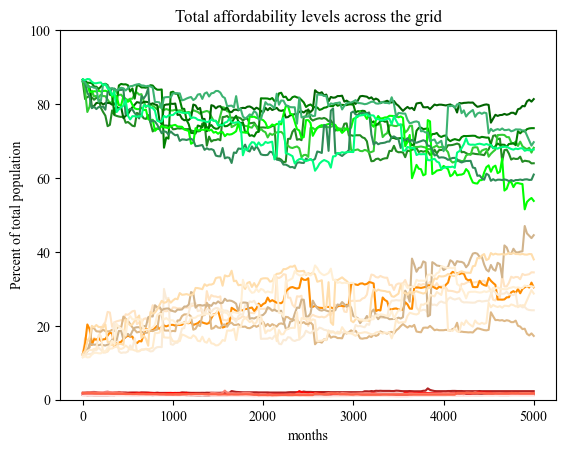

LEGEND
greeny-blue = affordable (< 5%)
browny-yellow = unaffordable (> 5%)
reds = disconnected


In [6]:
graph_grid_wide_affordability(vector, MaxIter, True)

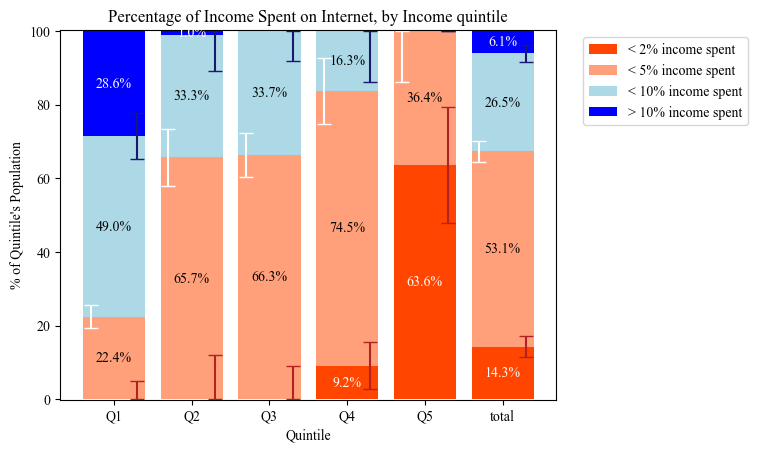

In [7]:
graph_aff_by_quint_run_avg_with_err(vector, MaxIter-1)

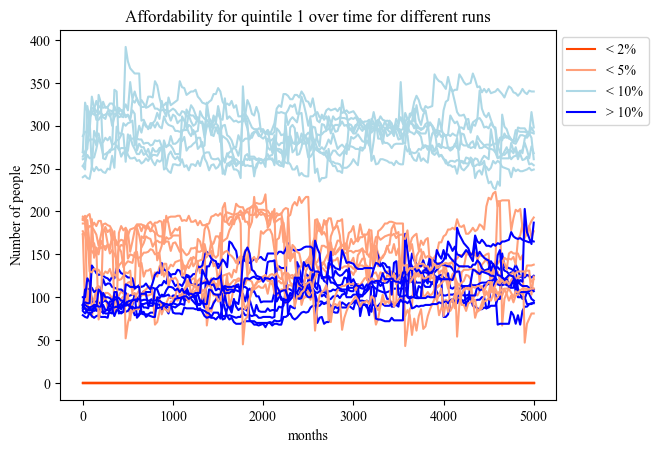

In [8]:
quintile = 1
graph_aff_by_quint_over_time(vector, quintile-1, MaxIter)

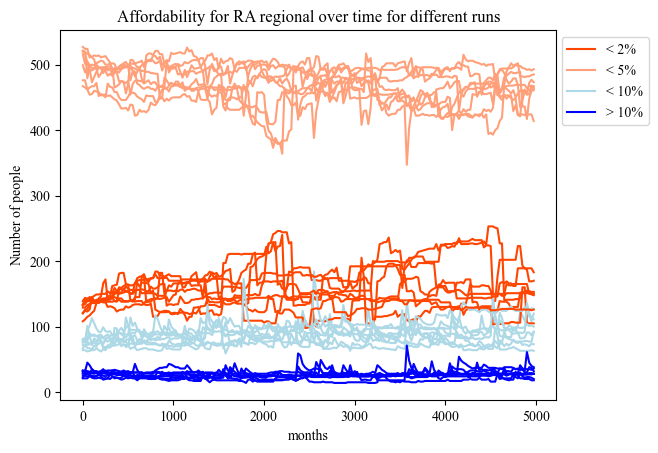

In [9]:
ra = 1
graph_aff_by_ra_over_time(vector, ra, MaxIter-1)

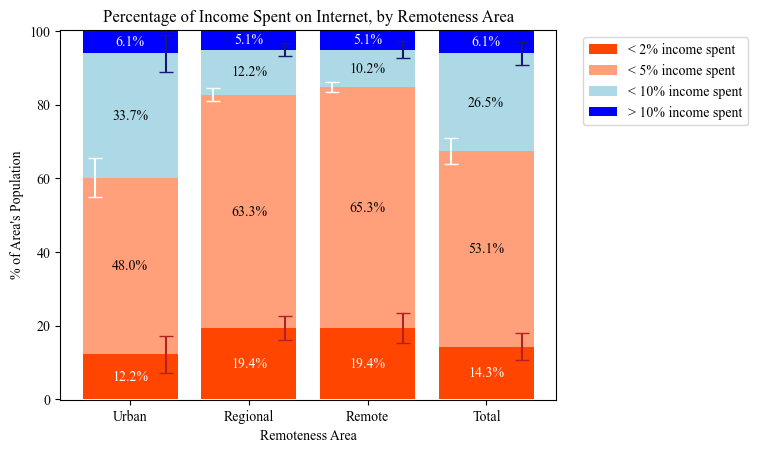

In [10]:
graph_aff_by_ra_run_avg_with_err(vector, MaxIter-1)

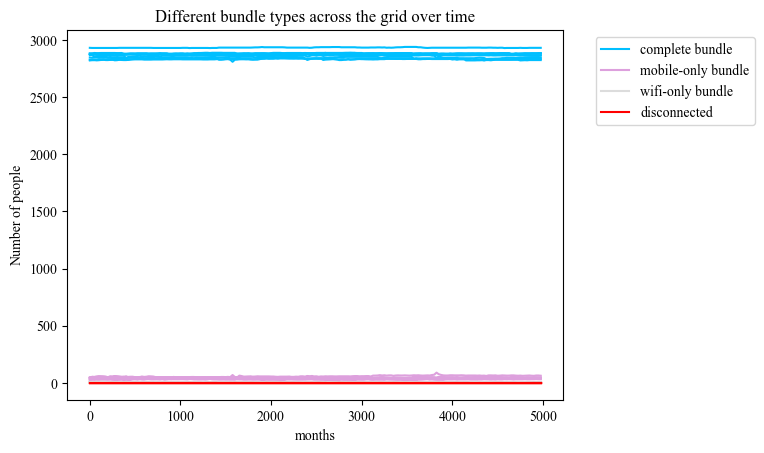

In [11]:
graph_all_bundle_types(vector, MaxIter-1)

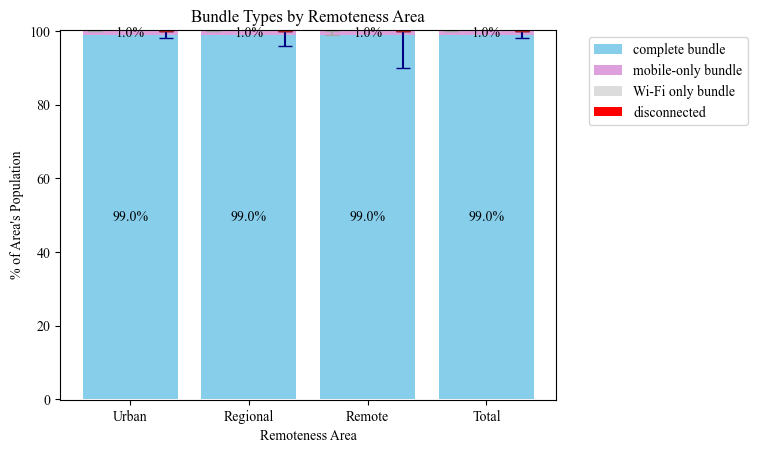

In [12]:
graph_bundles_by_ra(vector, MaxIter-1)

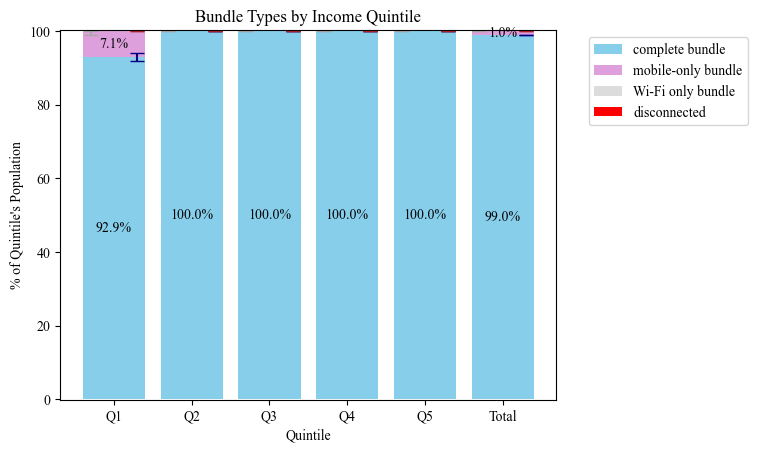

In [13]:
graph_bundles_by_quintile(vector, MaxIter-1)

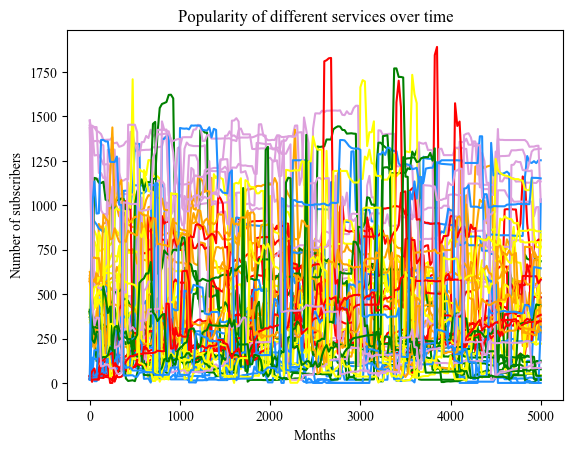

In [21]:
#can graph on four settings:
# setting 0 = (0, None) -> graph every run, every NBN speed tier
# setting 1 = (1, *r*) -> graph every NBN speed tier for run r (runs between 0 to num_runs)
# setting 2 = (2, *t*) -> graph every run, NBN speed tier t (speed teirs 0 to 5)
# setting 3 = (3, (*r*, *t*)) -> graph run r, speed tier t only
graph_subs_over_time(vector, MaxIter, (0, 3))

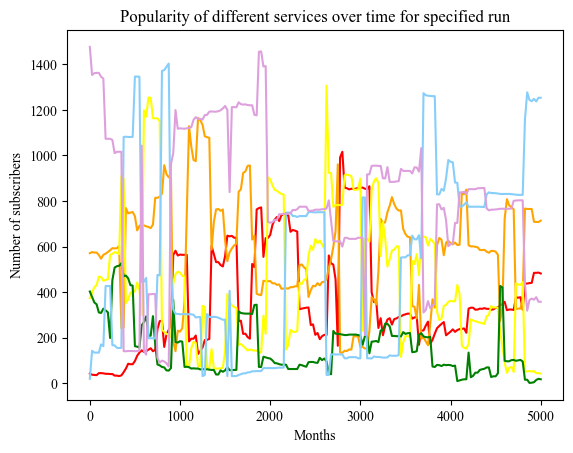

In [22]:
#can graph on four settings:
# setting 0 = (0, None) -> graph every run, every NBN speed tier
# setting 1 = (1, *r*) -> graph every NBN speed tier for run r (runs between 0 to num_runs)
# setting 2 = (2, *t*) -> graph every run, NBN speed tier t (speed teirs 0 to 5)
# setting 3 = (3, (*r*, *t*)) -> graph run r, speed tier t only
graph_subs_over_time(vector, MaxIter, (1, 3))

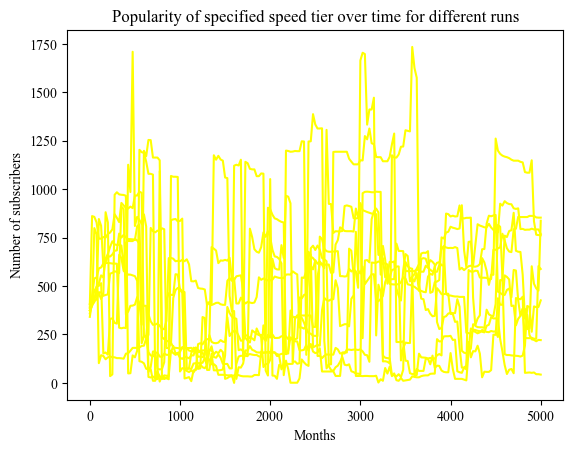

In [24]:
#can graph on four settings:
# setting 0 = (0, None) -> graph every run, every NBN speed tier
# setting 1 = (1, *r*) -> graph every NBN speed tier for run r (runs between 0 to num_runs)
# setting 2 = (2, *t*) -> graph every run, NBN speed tier t (speed teirs 0 to 5)
# setting 3 = (3, (*r*, *t*)) -> graph run r, speed tier t only
graph_subs_over_time(vector, MaxIter, (2, 2))

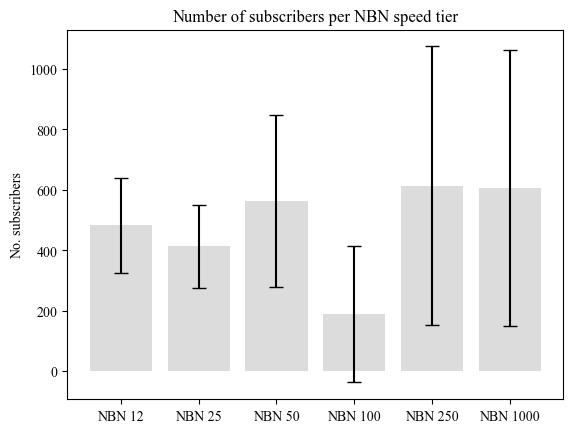

In [15]:
graph_subs(vector, MaxIter-1)

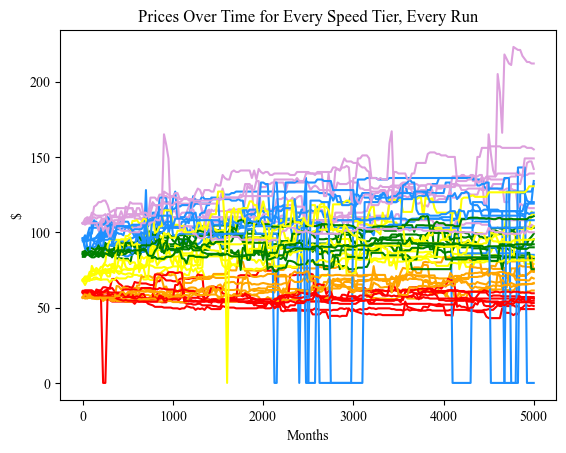

In [16]:
#can graph on three settings:
# setting 0: (0, None) -> graph all runs, all speed tiers
# setting 1: (1, r) -> graph run r all speed tiers (r between 0-num_runs)
# setting 2: (2, t) -> graph all runs speed tier t (t between 0-5)
graph_wifi_prices_over_time_grid_wide(vector, MaxIter, (0, 3))

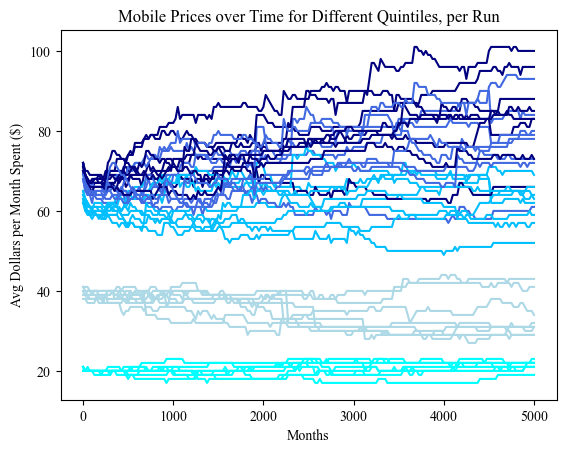

In [17]:
#can graph on three settings:
# setting 0: (0, None) -> graph all runs, all quintiles
# setting 1: (1, r) -> graph run r all quintiles
# setting 2: (2, q) -> graph all runs quintile q
graph_mobile_quintile_prices_over_time(vector, MaxIter, (0, 0))

[102617, 34781, 56]


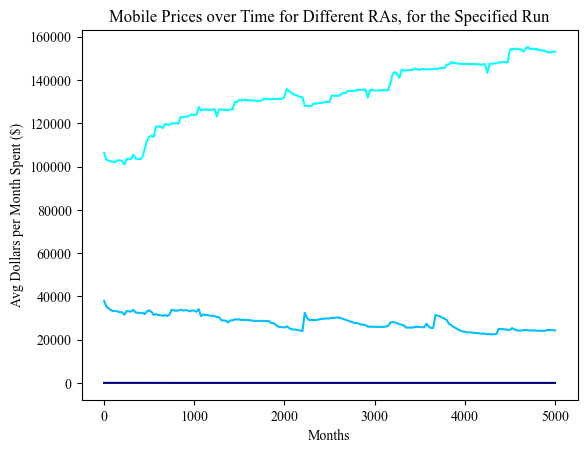

In [18]:
#can graph on three settings:
# setting 0: (0, None) -> graph all runs, all quintiles
# setting 1: (1, r) -> graph run r all quintiles
# setting 2: (2, q) -> graph all runs quintile q
graph_mobile_ra_prices_over_time(vector, MaxIter, (1, 4))

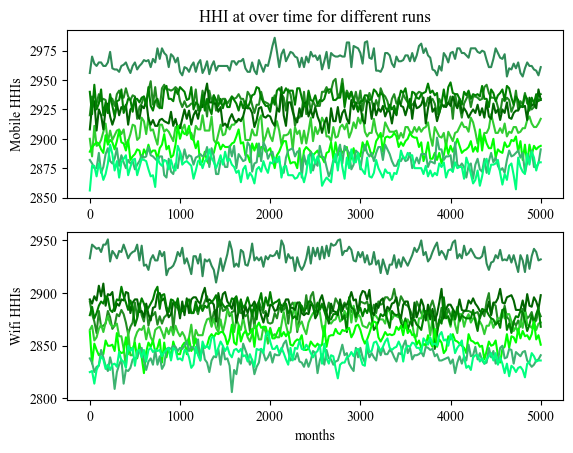

In [19]:
graph_HHIs(vector, MaxIter)